### Introduction

The work is used to check the product matching of the items. Models are trained with certain algorithsm and the best one is employed for product matching.

### Mounting folder in Gdrive to Colab
Make sure you have uploaded the entire project folder in your own google drive first. Refer this [link](https://www.youtube.com/watch?v=iUnF8KGX6nk). Also while selecting the runtime make sure to select **GPU instance** as code need gpu to run.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
path='/content/drive/MyDrive/mscproject'

#path = '/content/drive/MyDrive/mscproject'

import os
os.chdir(path)
!ls

computers_train_xlarge.json  testset_1500.json


### Pre-requisites

In [3]:
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!pip install jellyfish
!pip install fuzzywuzzy
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-06 15:33:47.660101: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-06 15:33:59.631594: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in

Loading the required libraries

In [4]:
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import spacy

import jellyfish as jf
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,f1_score,accuracy_score,mean_absolute_error,precision_score,recall_score,confusion_matrix,roc_auc_score

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
from IPython.display import HTML
def pretty_print_df(value_counts_):
  display(HTML(pd.DataFrame(value_counts_).to_html()))

#### Data loading

In [6]:
tset = pd.read_json(path+'/computers_train_xlarge.json', orient="records", lines=True)
tset

,id_left,category_left,cluster_id_left,id_right,category_right,cluster_id_right,label,pair_id,brand_left,brand_right,description_left,description_right,keyValuePairs_left,keyValuePairs_right,price_left,price_right,specTableContent_left,specTableContent_right,title_left,title_right
0,2551242,Computers_and_Accessories,79457,16272671,Computers_and_Accessories,79457,1,2551242#16272671,"""Corsair""@en",None,"""DDR4, 2666MHz, CL16, 1.2v, XMP 2.0, Lifetime ...",None,"{'Memory Type': 'DDR4 (PC4-21300)', 'Capacity'...","{'Categorie': 'Geheugen intern', 'Merk': 'Cors...",None,None,Memory Type DDR4 (PC4-21300) Capacity 64GB (4...,Categorie Geheugen intern Merk Corsair Produc...,"""Corsair Vengeance LPX Black 64GB (4x16GB) DD...","""Corsair Vengeance LPX CMK64GX4M4A2666C16 - P..."
1,16757469,Computers_and_Accessories,63553,16476204,Computers_and_Accessories,63553,1,16757469#16476204,"""HP Enterprise""","""HP Enterprise""","""Description:2 x 72GB 2.5-inch Serial Attached...","""Description:10 x 72GB 2.5-inch Serial Attach...","{'Category': 'Proliant HardDrive', 'Sub-Catego...","{'Category': 'Proliant HardDrive', 'Sub-Catego...",None,"""CAD"", ""$757.74 CAD""",Specifications: Category Proliant HardDrive S...,Specifications: Category Proliant HardDrive S...,"""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"", ""Nu...","""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"" ""Null"""
2,232007,Computers_and_Accessories,212917,16442945,Computers_and_Accessories,14319765,0,232007#16442945,"""SanDisk""","""HP Enterprise""","""SDSDJ-1024 BXP 1GB 9p SD Class 2 Secure Digi...","""Description:Genuine HPE 1GB FBD PC2-5300(2x5...",None,"{'Category': 'Proliant Memory', 'Sub-Category'...","""USD"", ""7.98""","""USD"", ""$69.95""",None,Specifications: Category Proliant Memory Sub-...,"""SanDisk SDSDJ-1024 BXP 1GB 9p SD Class 2 Sec...","""397409-B21 HP 1GB (2x512MB) PC2-5300 SDRAM"" ..."
3,2066119,Computers_and_Accessories,667772,12411100,Computers_and_Accessories,667772,1,2066119#12411100,None,"""KINGSTON""","""DISCO DURO INTERNO SOLIDO HDD SSD""@es",None,None,None,None,None,None,None,"""DISCO DURO INTERNO SOLIDO HDD SSD KINGSTON V...","""DISCO DURO SSD Kingston Technology SSDNow V3..."
4,6656540,Computers_and_Accessories,505997,2639431,Computers_and_Accessories,154118,0,6656540#2639431,None,"""Corsair""",None,None,None,None,None,None,None,None,"""Corsair Vengeance LED 32GB (2 x 16GB) DDR4 D...","""Corsair - Vengeance LPX 32GB (2 x 16GB) DDR4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68456,6493497,Computers_and_Accessories,222681,16149764,Computers_and_Accessories,502396,0,6493497#16149764,"""HP Enterprise""","""HP Enterprise""","""Description:5 x 300GB 2.5-inch Serial Attache...","""Description:2 x 72GB 2.5-inch Serial Attache...","{'Category': 'Proliant HardDrive', 'Sub-Catego...","{'Category': 'Proliant HardDrive', 'Sub-Catego...",None,"""$151.40"", ""USD""",Specifications: Category Proliant HardDrive S...,Specifications: Category Proliant HardDrive S...,"""DG0300FARVV HP 300-GB 6G 10K 2.5 DP SAS"", ""N...","""Null"" ""512743-001 HP 72-GB 6G 15K 2.5 DP SAS"""
68457,17075265,Computers_and_Accessories,944407,17346839,Computers_and_Accessories,825203,0,17075265#17346839,"""Samsung""",None,None,"""Cost-effective SSD featuring TurboWrite and ...",None,None,None,None,None,None,"""Samsung - 840 EVO 250GB 2.5"" Solid State Dri...","""SSD 750 EVO 2.5” SATA III 120GB ""@en"
68458,16408794,Computers_and_Accessories,144052,3675781,Computers_and_Accessories,51801,0,16408794#3675781,"""INTEL""@fr","""Intel""@en",None,"""Quad Core Technology, 3.6GHz clock speed, 8MB...",None,"{'Processor Number': 'I7 7700', 'Number of Cor...",None,None,None,Processor Number I7 7700 Number of Cores 4 Nu...,"""Socket H4 1151 - Coffee Lake Core i7-8700K 6...","""7th Generation Intel® Core™ i7 7700 3.6GHz S..."
68459,13925964,Computers_and_Accessories,43816,15659664,Computers_and_Accessories,478188,0,13925964#15659664,None,None,"""Built to WD's highest standards

#### Data analysis

 

Getting the shape of the dataset

In [70]:
tset.shape

(68461, 20)

analyse the number of invalid data in the given dataset

In [71]:
tset.isnull().sum()

id_left                       0
category_left                 0
cluster_id_left               0
id_right                      0
category_right                0
cluster_id_right              0
label                         0
pair_id                       0
brand_left                34228
brand_right               34216
description_left          21001
description_right         20101
keyValuePairs_left        49696
keyValuePairs_right       48186
price_left                56940
price_right               56969
specTableContent_left     47564
specTableContent_right    46304
title_left                    0
title_right                   0
dtype: int64

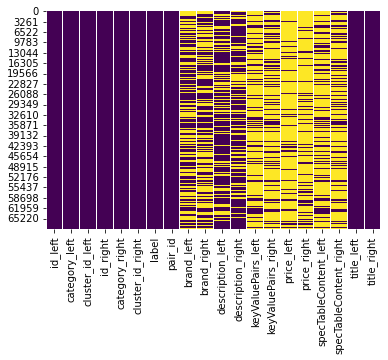

In [72]:
sns.heatmap(tset.isnull(),cbar=False,cmap='viridis')

Impute the columns brand left and right with the column mode value

In [77]:
tset['brand_left'].mode()


0    HP Enterprise
dtype: object

In [78]:
tset['brand_left'].fillna('HP Enterprise', inplace= True)
tset['brand_left'].isnull().sum()

0

In [79]:
tset['brand_right'].mode()


0    HP Enterprise
dtype: object

In [80]:
tset['brand_right'].fillna('HP Enterprise', inplace= True)
tset['brand_right'].isnull().sum()

0

Remove all the invalid characters from the price left and right columns

In [81]:
tset['price_left']=tset['price_left'].str.replace(r"[\"'a,$?@en''CAD/USD]",'')

<ipython-input-81-a467f94c2ff7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tset['price_left']=tset['price_left'].str.replace(r"[\"'a,$?@en''CAD/USD]",'')


In [82]:
tset['price_right']=tset['price_right'].str.replace(r"[\"'a,$?@en''CAD/USD]",'')

<ipython-input-82-c2ad7758a0b5>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tset['price_right']=tset['price_right'].str.replace(r"[\"'a,$?@en''CAD/USD]",'')


Getting the count of the entries have categorical columns

In [7]:
categorical_columns= ['title_left', 'title_right','brand_left','brand_right']

for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(tset[col].value_counts())

Categories and number of occurrences for 'title_left'


,title_left
"""DISCO DURO INTERNO SOLIDO HDD SSD""",45
"""AMD A series A6-5400K"" ""Comprar AMD A6-5400K - PowerPlanetOnline""",43
"""Speck SeeThru MacBook Air 13"" - notebook hardshell case"" "" Speck case 71482-B189 Sleeve/Shuttle Notebook Cases CDW.com",42
"""Corsair Air Series SP120 PWM Quiet Edition Twin Pack, 120mm - Prijzen ""@NL Pack Tweakers""@NL",42
"""AMD A6 5400K Black Edition Dual Core APU 3.8/3.6GHZ Processor FM2 1MB Cache 65W Retail Box"" Box - AD540KOKHJBOX NCIX""",41
"""MSI AMD AM4 Ryzen B350 TOMAHAWK ATX Motherboard""@en Motherboard LN79116 | SCAN UK""@en",40
"""DS1517+ 5 Bay Synology Desktop NAS Enclosure with 8GB""@en 8GB LN80187 - DS1517+ (8GB) | SCAN UK""@en",40
"""Portable USB 3.0 to VGA Adapter from StarTech.com""@en StarTech.com LN69871 - USB32VGAES | SCAN UK""@en",40
"""Intel Core i5-4670K"" ""Comprar Intel i5-4670K em PowerPlanetOnline""",40
"""Samsung""@en ""LambdaTek|internal solid state drives""@en",39


Categories and number of occurrences for 'title_right'


,title_right
"""Transcend Ultimate - flash memory card 32 GB microSDHC UHS-I"" "" Transcend UHS-I TS32GUSDU3 Flash Memory Cards CDW.com",116
"""Transcend Ultimate - flash memory card 32 GB microSDHC UHS-I"" "" Transcend UHS-I TS32GUSDU3 Flash Memory Cards CDWG.com",107
"""Transcend Micro SDHC UHS-I U3 32 GB Class 10 Memory Card + Adapter - 95 MB""@en",106
"""Apple 12.9-inch iPad Pro Wi-Fi - tablet 32 GB 12.9"""" "" Apple 12.9"" ML0H2LL/A Tablets CDW.com",97
"""454141-002 HP 500-GB 7.2K 3.5 SATA"", ""Null"" Price 454141-002-10Pack"" SATA 10 Pack Wholesale 454141-002",97
"""454141-002 HP 500-GB 7.2K 3.5 SATA"", ""Null"" ""New 454141-002 SATA 10 Pack Wholesale Price 454141-002-10Pack""",91
"""287497-B21 HP 1GB 266MHz DDR PC2100"", ""Null"" ""New 287497-B21 PC2100 Wholesale Price 287497-B21""",87
"""Apple - 12.9- Inch iPad Pro with Wi-Fi 32 GB Gold""@en-US",87
"""432806-B21 HP 2GB PC2-5300 SDRAM Module"", ""Null"" Price 432806-B21"" ""New 432806-B21 Module Wholesale",78
"""Western Digital""@en ""LambdaTek|internal solid state drives""@en",76


Categories and number of occurrences for 'brand_left'


,brand_left
"""HP Enterprise""",9069
"""Corsair""@en",1571
"""Intel""@en",1314
"""Intel""",765
"""Seagate""",726
"""AMD""",719
"""Asus""@en",682
"""Apple""@en",602
"""AMD""@en",575
"""SanDisk""",567


Categories and number of occurrences for 'brand_right'


,brand_right
"""HP Enterprise""",10539
"""Corsair""@en",1940
"""Intel""@en",1477
"""Asus""@en",809
"""Null""",798
"""Apple""@en",786
"""Intel""",689
"""Corsair""",668
"""AMD""@en",666
"""Seagate""",626


Getting the total count title occurences

In [8]:
tset.isnull().sum()

id_left                       0
category_left                 0
cluster_id_left               0
id_right                      0
category_right                0
cluster_id_right              0
label                         0
pair_id                       0
brand_left                34228
brand_right               34216
description_left          21001
description_right         20101
keyValuePairs_left        49696
keyValuePairs_right       48186
price_left                56940
price_right               56969
specTableContent_left     47564
specTableContent_right    46304
title_left                    0
title_right                   0
dtype: int64

Making a copy of the existing dataframe and storing in variable df. Here we are only selecting the titles and its label. The title left is the product title that is mentioned in the website and the title right is the actual product name. The label denotes whether they are same or not

In [10]:
df= tset[['title_left', 'title_right', 'label']].copy()
df

,title_left,title_right,label
0,"""Corsair Vengeance LPX Black 64GB (4x16GB) DD...","""Corsair Vengeance LPX CMK64GX4M4A2666C16 - P...",1
1,"""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"", ""Nu...","""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"" ""Null""",1
2,"""SanDisk SDSDJ-1024 BXP 1GB 9p SD Class 2 Sec...","""397409-B21 HP 1GB (2x512MB) PC2-5300 SDRAM"" ...",0
3,"""DISCO DURO INTERNO SOLIDO HDD SSD KINGSTON V...","""DISCO DURO SSD Kingston Technology SSDNow V3...",1
4,"""Corsair Vengeance LED 32GB (2 x 16GB) DDR4 D...","""Corsair - Vengeance LPX 32GB (2 x 16GB) DDR4...",0
...,...,...,...
68456,"""DG0300FARVV HP 300-GB 6G 10K 2.5 DP SAS"", ""N...","""Null"" ""512743-001 HP 72-GB 6G 15K 2.5 DP SAS""",0
68457,"""Samsung - 840 EVO 250GB 2.5"" Solid State Dri...","""SSD 750 EVO 2.5” SATA III 120GB ""@en",0
68458,"""Socket H4 1151 - Coffee Lake Core i7-8700K 6...","""7th Generation Intel® Core™ i7 7700 3.6GHz S...",0
68459,"""WD Blue WD5000AZLX - hard drive 500 GB SATA ...","""m rock ships""@en-US ""M-ROCK Ships New Camera...",0


#### Data preprocessing

In [11]:
def matching_numbers(external_name, internal_name):

    external_numbers = set(re.findall(r'[0-9]+', external_name))
    internal_numbers = set(re.findall(r'[0-9]+', internal_name))    
    union = external_numbers.union(internal_numbers)
    intersection = external_numbers.intersection(internal_numbers)

    if len(external_numbers)==0 and len(internal_numbers) == 0:
        return 1
    else:
        return (len(intersection)/ len(union))

Taking the two title strings and then converting them into equivalent numerical representation. Then these two numerical representation distance are found out using various methods. The so found values are added entires via a new column in existing dataframe.

In [12]:
def extract_features(df):

    df['title_left'] = df['title_left'].str.lower()
    df['title_right'] = df['title_right'].str.lower()

    df['levenshtein_distance'] = df.apply(
    lambda x: jf.levenshtein_distance(x['title_left'], 
                                      x['title_right']), axis=1)

    df['damerau_levenshtein_distance'] = df.apply(
    lambda x: jf.damerau_levenshtein_distance(x['title_left'], 
                                              x['title_right']), axis=1)

    df['hamming_distance'] = df.apply(
    lambda x: jf.hamming_distance(x['title_left'], 
                                  x['title_right']), axis=1)

    df['jaro_similarity'] = df.apply(
    lambda x: jf.jaro_similarity(x['title_left'], 
                                  x['title_right']), axis=1)

    df['jaro_winkler_similarity'] = df.apply(
    lambda x: jf.jaro_winkler_similarity(x['title_left'], 
                                         x['title_right']), axis=1)

    df['match_rating_comparison'] = df.apply(
    lambda x: jf.match_rating_comparison(x['title_left'], 
                                         x['title_right']), axis=1).fillna(0).astype(int)

    df['ratio'] = df.apply(
    lambda x: fuzz.ratio(x['title_left'], 
                         x['title_right']), axis=1)

    df['partial_ratio'] = df.apply(
    lambda x: fuzz.partial_ratio(x['title_left'], 
                                 x['title_right']), axis=1)

    df['token_sort_ratio'] = df.apply(
    lambda x: fuzz.token_sort_ratio(x['title_left'], 
                                    x['title_right']), axis=1)

    df['token_set_ratio'] = df.apply(
    lambda x: fuzz.token_set_ratio(x['title_left'], 
                                   x['title_right']), axis=1)

    df['w_ratio'] = df.apply(
    lambda x: fuzz.WRatio(x['title_left'], 
                          x['title_right']), axis=1)

    df['uq_ratio'] = df.apply(
    lambda x: fuzz.UQRatio(x['title_left'], 
                          x['title_right']), axis=1)

    df['q_ratio'] = df.apply(
    lambda x: fuzz.QRatio(x['title_left'], 
                          x['title_right']), axis=1)    

    df['matching_numbers'] = df.apply(
    lambda x: matching_numbers(x['title_left'], 
                               x['title_right']), axis=1)

    df['matching_numbers_log'] = (df['matching_numbers']+1).apply(np.log)

    df['log_fuzz_score'] = (df['ratio'] + df['partial_ratio'] + 
                            df['token_sort_ratio'] + df['token_set_ratio']).apply(np.log)

    df['log_fuzz_score_numbers'] = df['log_fuzz_score'] + (df['matching_numbers']).apply(np.log)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(value=0, inplace=True)

    return df

In [16]:
import pandas as pd
import gensim

#df = extract_features(df)
#df.to_csv(path+'/extracted_features.csv')

df=pd.read_csv(path+'/extracted_features.csv')
df

,Unnamed: 0,title_left,title_right,label,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,...,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
0,0,"""corsair vengeance lpx black 64gb (4x16gb) dd...","""corsair vengeance lpx cmk64gx4m4a2666c16 - p...",1,82,82,103,0.713380,0.828028,1,...,54,50,80,86,46,46,0.800000,0.587787,5.446737,5.223594
1,1,"""dh0072balwl hp 72-gb 3g 15k 2.5 dp sas"", ""nu...","""dh0072balwl hp 72-gb 3g 15k 2.5 dp sas"" ""null""",1,64,64,70,0.809524,0.885714,1,...,98,59,100,88,58,58,1.000000,0.693147,5.758902,5.758902
2,2,"""sandisk sdsdj-1024 bxp 1gb 9p sd class 2 sec...","""397409-b21 hp 1gb (2x512mb) pc2-5300 sdram"" ...",0,55,55,65,0.546538,0.546538,0,...,35,30,32,31,31,31,0.250000,0.223144,4.820282,3.433987
3,3,"""disco duro interno solido hdd ssd kingston v...","""disco duro ssd kingston technology ssdnow v3...",1,77,76,98,0.724734,0.834841,1,...,48,47,57,54,49,49,0.333333,0.287682,5.308268,4.209655
4,4,"""corsair vengeance led 32gb (2 x 16gb) ddr4 d...","""corsair - vengeance lpx 32gb (2 x 16gb) ddr4...",0,52,52,93,0.724344,0.834606,1,...,57,66,68,65,57,57,1.000000,0.693147,5.513429,5.513429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68456,68456,"""dg0300farvv hp 300-gb 6g 10k 2.5 dp sas"", ""n...","""null"" ""512743-001 hp 72-gb 6g 15k 2.5 dp sas""",0,92,92,110,0.571127,0.571127,0,...,64,41,73,86,35,35,0.300000,0.262364,5.375278,4.171306
68457,68457,"""samsung - 840 evo 250gb 2.5"" solid state dri...","""ssd 750 evo 2.5” sata iii 120gb ""@en",0,57,57,79,0.621066,0.621066,0,...,47,45,51,86,38,38,0.285714,0.251314,5.159055,3.906292
68458,68458,"""socket h4 1151 - coffee lake core i7-8700k 6...","""7th generation intel® core™ i7 7700 3.6ghz s...",0,106,106,128,0.637071,0.637071,0,...,39,41,47,86,35,35,0.400000,0.336472,5.087596,4.171306
68459,68459,"""wd blue wd5000azlx - hard drive 500 gb sata ...","""m rock ships""@en-us ""m-rock ships new camera...",0,89,89,103,0.589564,0.589564,0,...,20,32,35,33,20,20,0.000000,0.000000,4.644391,0.000000


In [17]:
df[df.columns[1:]].corr()['ratio'][:].sort_values(ascending=False)

ratio                           1.000000
uq_ratio                        0.967384
q_ratio                         0.967248
log_fuzz_score                  0.905168
token_sort_ratio                0.875750
partial_ratio                   0.872179
jaro_similarity                 0.832275
jaro_winkler_similarity         0.813694
token_set_ratio                 0.813137
log_fuzz_score_numbers          0.482465
match_rating_comparison         0.474734
matching_numbers                0.467099
matching_numbers_log            0.463953
w_ratio                         0.383337
label                           0.284742
hamming_distance               -0.407518
damerau_levenshtein_distance   -0.676133
levenshtein_distance           -0.676184
Name: ratio, dtype: float64

Normalising the and seperating the dataset into input features(X) and labels(y). Now this numpy array is splitted into training(70%) and testing(30%) using the train test split.

In [18]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
y = df['label'].values

# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

print(X)
print(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

[[ 82.  82. 103. ...  46.  46.  86.]
 [ 64.  64.  70. ...  58.  58.  88.]
 [ 55.  55.  65. ...  31.  31.  31.]
 ...
 [106. 106. 128. ...  35.  35.  86.]
 [ 89.  89. 103. ...  20.  20.  33.]
 [ 90.  90. 110. ...  29.  29.  86.]]
[1 1 0 ... 0 0 0]
(47922, 16)
(47922,)
(20539, 16)
(20539,)


Here we are passing the train test split data into different classfication algorithm to train the model. The output accuracies are observed and the best fit model is then used for our product matching application.

In [19]:
import joblib
def get_confusion_matrix_values(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

classifiers = {
    "KNeighborsClassifier":KNeighborsClassifier(3),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "AdaBoostClassifier":AdaBoostClassifier(),
    "Logistic Regression": LogisticRegression()
}

df_results = pd.DataFrame(columns=['model', 'accuracy', 'mae','run_time','tp','fp',
                                   'tn','fn'])
count=0
for key in classifiers:
    print(key)

    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train, y_train)
    filename = path+'/finalized_model_{}.sav'.format(key)
    joblib.dump(model, filename)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    classification = classification_report(y_test, y_pred, zero_division=0)
    run_time = format(round((time.time() - start_time)/60,2))
    tp, fp, fn, tn = get_confusion_matrix_values(y_test, y_pred)

    row = {'model': key,
           'accuracy': accuracy,
           'mae': mae,
           'run_time': run_time,
           'tp': tp,
           'fp': fp,
           'tn': tn,
           'fn': fn,
          }
    df_results = df_results.append(row, ignore_index=True)
    count=count+1

df_results.head(10)
#print(y_pred)

KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
Logistic Regression


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,accuracy,mae,run_time,tp,fp,tn,fn
0,KNeighborsClassifier,0.896733,0.103267,0.31,16954,660,1464,1461
1,DecisionTreeClassifier,0.890598,0.109402,0.01,16470,1144,1822,1103
2,RandomForestClassifier,0.928818,0.071182,0.23,17260,354,1817,1108
3,AdaBoostClassifier,0.914748,0.085252,0.06,17252,362,1536,1389
4,Logistic Regression,0.906227,0.093773,0.02,17242,372,1371,1554


## Testing
Here we will test to see of both the product names are matching or not. Random forest model will be used as it gave the maximum accuracy

Examples of same:  

-  "disco duro interno solido hdd ssd kingston v300 120gb 2.5" sata 600"@es 600 - inusnet.com inside-pc baza"@es ;  "disco duro ssd kingston technology ssdnow v300 120gb sata3" "comprar disco sata3disco sata3 - powerplanetonline"
-  "hp pavilion x360 - 11-ad018ca"@en ;  "hp pavilion x360 - 11-ad018ca"@en 11-ad018ca hp store canada"@en
-  " apple macbook air mjvm2ll/a 11.6-inch laptop (1.6 ghz intel core i5; 128 gb hard drive; integrated hd graphics 6000; mac os x 10.10 yosemite) "@en-us "apple i5 drive i"@en-us ;  "macbook air 11.6-inch (glossy) 1.6ghz dual core i5 (early 2015) . - apple mjvm2ll/a" " used and refurbished macbook airs on sale | gainsaver

Different:
-  "sandisk sdsdj-1024 bxp 1gb 9p sd class 2 secure digital card bulk rfb" ;  "397409-b21 hp 1gb (2x512mb) pc2-5300 sdram" "null"
-  "corsair vengeance - ddr3 8 gb : 2 x 4 so-dimm 204-pin" " corsair 204-pin cmsx8gx3m2a1600c9 system memory (ram) cdw.com ;  "corsair vengeance black cmz16gx3m2a1600c10 16gb 2x8gb ddr3-1600 cl10 1.5v dual channel memory kit" 2x8gb ddr3 1600mhz - ncix"
-  "hp elite x2 1012 g1 2 en 1 core m7-6y65 8gb 256gb ssd 4g lte tactil 12 w10pro"@es spectre pro g2 x360 i7-6600u 512gb 13.3 fhd w10pr... "@es ;  "asus zenbook 3 ux390ua-gs042t i5-7200u 8gb 256gb ssd 12.5 w10 azul; oro"@es transformer book t101ha-gr034t 2 en 1 z8350 4gb 128gb 10.1... "@es
-  "msi gtx 1080 gaming x 8g - graphics card gf 8 gb" " msi gb video cards cdw.com ;  "asus nvidia geforce gtx 1070 turbo 8gb graphics card"@en card ln73835 - turbo-gtx1070-8g | scan uk"@en
-  "prodesk 600 sff + monitor"@es monitor - hp store españa"@es ;  "hp zbook studio g3 i7-6700hq 8gb 256gb ssd m1000 4gb 15.6 fhd w7pro"@es omen 15-ax209ns i7-7700hq 1tb nvidia gtx1050 2gb freedos 15.... "@es

In [35]:
#Example 1, Matching products
#"disco duro interno solido hdd ssd kingston v300 120gb 2.5" sata 600"@es 600 - inusnet.com inside-pc baza"@es
#"disco duro ssd kingston technology ssdnow v300 120gb sata3" "comprar disco sata3disco sata3 - powerplanetonline"


prod1=str(input("Enter the first product name : "))
prod2=str(input("Enter the second product name : "))


print(prod1,prod2)

Enter the first product name : "disco duro interno solido hdd ssd kingston v300 120gb 2.5" sata 600"@es 600 - inusnet.com inside-pc baza"@es
Enter the second product name : "disco duro ssd kingston technology ssdnow v300 120gb sata3" "comprar disco sata3disco sata3 - powerplanetonline"
"disco duro interno solido hdd ssd kingston v300 120gb 2.5" sata 600"@es 600 - inusnet.com inside-pc baza"@es "disco duro ssd kingston technology ssdnow v300 120gb sata3" "comprar disco sata3disco sata3 - powerplanetonline"


In [36]:
df=pd.DataFrame(columns=['title_left','title_right'])
df.at[1,'title_left']=prod1
df.at[1,'title_right']=prod2
df

,title_left,title_right
1,"""disco duro interno solido hdd ssd kingston v3...","""disco duro ssd kingston technology ssdnow v30..."


In [37]:
df=extract_features(df)
df

,title_left,title_right,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,ratio,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
1,"""disco duro interno solido hdd ssd kingston v3...","""disco duro ssd kingston technology ssdnow v30...",77,76,98,0.721926,0.833156,1,50,48,47,57,54,49,49,0.333333,0.287682,5.308268,4.209655


In [38]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
print(X)
# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

# print(X)

[[77.         76.         98.          0.72192593  0.83315556  0.28768207
   0.33333333 57.         47.         48.         50.          5.3082677
   4.20965541 49.         49.         54.        ]]


In [39]:
import joblib

model=joblib.load(path+'/finalized_model_RandomForestClassifier.sav')
out=model.predict(X)[0]
print(out)

if out==1:
  print("The products are matching")
else:
  print("The products are not matching")

1
The products are matching


In [40]:
#Example 2 Matching products
#"hp pavilion x360 - 11-ad018ca"@en
#"hp pavilion x360 - 11-ad018ca"@en 11-ad018ca hp store canada"@en

prod1=str(input("Enter the first product name : "))
prod2=str(input("Enter the second product name : "))


print(prod1,prod2)

Enter the first product name : "hp pavilion x360 - 11-ad018ca"@en
Enter the second product name : "hp pavilion x360 - 11-ad018ca"@en 11-ad018ca hp store canada"@en
"hp pavilion x360 - 11-ad018ca"@en "hp pavilion x360 - 11-ad018ca"@en 11-ad018ca hp store canada"@en


In [41]:
df=pd.DataFrame(columns=['title_left','title_right'])
df.at[1,'title_left']=prod1
df.at[1,'title_right']=prod2
df

,title_left,title_right
1,"""hp pavilion x360 - 11-ad018ca""@en","""hp pavilion x360 - 11-ad018ca""@en 11-ad018ca ..."


In [42]:
df=extract_features(df)
df

,title_left,title_right,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,ratio,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
1,"""hp pavilion x360 - 11-ad018ca""@en","""hp pavilion x360 - 11-ad018ca""@en 11-ad018ca ...",31,31,31,0.841026,0.904615,1,69,100,67,100,90,68,68,1.0,0.693147,5.817111,5.817111


In [43]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
print(X)
# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

# print(X)

[[ 31.          31.          31.           0.84102564   0.90461538
    0.69314718   1.         100.          67.         100.
   69.           5.81711116   5.81711116  68.          68.
   90.        ]]


In [44]:
import joblib

model=joblib.load(path+'/finalized_model_RandomForestClassifier.sav')
out=model.predict(X)[0]
print(out)

if out==1:
  print("The products are matching")
else:
  print("The products are not matching")

1
The products are matching


In [50]:
#Example 3 Matching products: 
#" apple macbook air mjvm2ll/a 11.6-inch laptop (1.6 ghz intel core i5; 128 gb hard drive; integrated hd graphics 6000; mac os x 10.10 yosemite) "@en-us "apple i5 drive i"@en-us ; 
#"macbook air 11.6-inch (glossy) 1.6ghz dual core i5 (early 2015) . - apple mjvm2ll/a" " used and refurbished macbook airs on sale | gainsaver

prod1=str(input("Enter the first product name : "))
prod2=str(input("Enter the second product name : "))


print(prod1,prod2)

Enter the first product name : " apple macbook air mjvm2ll/a 11.6-inch laptop (1.6 ghz intel core i5; 128 gb hard drive; integrated hd graphics 6000; mac os x 10.10 yosemite) "@en-us "apple i5 drive i"@en-us
Enter the second product name : "macbook air 11.6-inch (glossy) 1.6ghz dual core i5 (early 2015) . - apple mjvm2ll/a" " used and refurbished macbook airs on sale | gainsaver
" apple macbook air mjvm2ll/a 11.6-inch laptop (1.6 ghz intel core i5; 128 gb hard drive; integrated hd graphics 6000; mac os x 10.10 yosemite) "@en-us "apple i5 drive i"@en-us "macbook air 11.6-inch (glossy) 1.6ghz dual core i5 (early 2015) . - apple mjvm2ll/a" " used and refurbished macbook airs on sale | gainsaver


In [51]:
df=pd.DataFrame(columns=['title_left','title_right'])
df.at[1,'title_left']=prod1
df.at[1,'title_right']=prod2
df

,title_left,title_right
1,""" apple macbook air mjvm2ll/a 11.6-inch laptop...","""macbook air 11.6-inch (glossy) 1.6ghz dual co..."


In [52]:
df=extract_features(df)
df

,title_left,title_right,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,ratio,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
1,""" apple macbook air mjvm2ll/a 11.6-inch laptop...","""macbook air 11.6-inch (glossy) 1.6ghz dual co...",120,120,166,0.719048,0.747144,0,18,46,51,57,54,19,19,0.555556,0.441833,5.147494,4.559708


In [53]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
print(X)
# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

# print(X)

[[120.         120.         166.           0.71904839   0.74714355
    0.44183275   0.55555556  57.          51.          46.
   18.           5.14749448   4.55970781  19.          19.
   54.        ]]


In [54]:
import joblib

model=joblib.load(path+'/finalized_model_RandomForestClassifier.sav')
out=model.predict(X)[0]
print(out)

if out==1:
  print("The products are matching")
else:
  print("The products are not matching")

1
The products are matching


In [55]:
#Example 4 Non-matching products
#"corsair vengeance - ddr3 8 gb : 2 x 4 so-dimm 204-pin" " corsair 204-pin cmsx8gx3m2a1600c9 system memory (ram) cdw.com ; 
#"corsair vengeance black cmz16gx3m2a1600c10 16gb 2x8gb ddr3-1600 cl10 1.5v dual channel memory kit" 2x8gb ddr3 1600mhz - ncix"

prod1=str(input("Enter the first product name : "))
prod2=str(input("Enter the second product name : "))


print(prod1,prod2)

Enter the first product name : "corsair vengeance - ddr3 8 gb : 2 x 4 so-dimm 204-pin" " corsair 204-pin cmsx8gx3m2a1600c9 system memory (ram) cdw.com
Enter the second product name : "corsair vengeance black cmz16gx3m2a1600c10 16gb 2x8gb ddr3-1600 cl10 1.5v dual channel memory kit" 2x8gb ddr3 1600mhz - ncix"
"corsair vengeance - ddr3 8 gb : 2 x 4 so-dimm 204-pin" " corsair 204-pin cmsx8gx3m2a1600c9 system memory (ram) cdw.com "corsair vengeance black cmz16gx3m2a1600c10 16gb 2x8gb ddr3-1600 cl10 1.5v dual channel memory kit" 2x8gb ddr3 1600mhz - ncix"


In [56]:
df=pd.DataFrame(columns=['title_left','title_right'])
df.at[1,'title_left']=prod1
df.at[1,'title_right']=prod2
df

,title_left,title_right
1,"""corsair vengeance - ddr3 8 gb : 2 x 4 so-dimm...","""corsair vengeance black cmz16gx3m2a1600c10 16..."


In [57]:
df=extract_features(df)
df

,title_left,title_right,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,ratio,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
1,"""corsair vengeance - ddr3 8 gb : 2 x 4 so-dimm...","""corsair vengeance black cmz16gx3m2a1600c10 16...",97,97,105,0.673836,0.673836,1,40,40,50,55,52,39,39,0.363636,0.310155,5.220356,4.208755


In [58]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
print(X)
# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

# print(X)

[[ 97.          97.         105.           0.67383594   0.67383594
    0.31015493   0.36363636  55.          50.          40.
   40.           5.22035583   4.20875491  39.          39.
   52.        ]]


In [59]:
import joblib

model=joblib.load(path+'/finalized_model_RandomForestClassifier.sav')
out=model.predict(X)[0]
print(out)

if out==1:
  print("The products are matching")
else:
  print("The products are not matching")

0
The products are not matching


In [60]:
#Example 5 Non-matching products
#"hp elite x2 1012 g1 2 en 1 core m7-6y65 8gb 256gb ssd 4g lte tactil 12 w10pro"@es spectre pro g2 x360 i7-6600u 512gb 13.3 fhd w10pr... "@es ; 
#"asus zenbook 3 ux390ua-gs042t i5-7200u 8gb 256gb ssd 12.5 w10 azul; oro"@es transformer book t101ha-gr034t 2 en 1 z8350 4gb 128gb 10.1... "@es

prod1=str(input("Enter the first product name : "))
prod2=str(input("Enter the second product name : "))


print(prod1,prod2)

Enter the first product name : "hp elite x2 1012 g1 2 en 1 core m7-6y65 8gb 256gb ssd 4g lte tactil 12 w10pro"@es spectre pro g2 x360 i7-6600u 512gb 13.3 fhd w10pr... "@es
Enter the second product name : "asus zenbook 3 ux390ua-gs042t i5-7200u 8gb 256gb ssd 12.5 w10 azul; oro"@es transformer book t101ha-gr034t 2 en 1 z8350 4gb 128gb 10.1... "@es
"hp elite x2 1012 g1 2 en 1 core m7-6y65 8gb 256gb ssd 4g lte tactil 12 w10pro"@es spectre pro g2 x360 i7-6600u 512gb 13.3 fhd w10pr... "@es "asus zenbook 3 ux390ua-gs042t i5-7200u 8gb 256gb ssd 12.5 w10 azul; oro"@es transformer book t101ha-gr034t 2 en 1 z8350 4gb 128gb 10.1... "@es


In [61]:
df=pd.DataFrame(columns=['title_left','title_right'])
df.at[1,'title_left']=prod1
df.at[1,'title_right']=prod2
df

,title_left,title_right
1,"""hp elite x2 1012 g1 2 en 1 core m7-6y65 8gb 2...","""asus zenbook 3 ux390ua-gs042t i5-7200u 8gb 25..."


In [62]:
df=extract_features(df)
df

,title_left,title_right,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,ratio,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
1,"""hp elite x2 1012 g1 2 en 1 core m7-6y65 8gb 2...","""asus zenbook 3 ux390ua-gs042t i5-7200u 8gb 25...",100,100,135,0.682351,0.682351,0,44,44,50,47,48,46,46,0.333333,0.287682,5.220356,4.121744


In [63]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
print(X)
# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

# print(X)

[[100.         100.         135.           0.68235098   0.68235098
    0.28768207   0.33333333  47.          50.          44.
   44.           5.22035583   4.12174354  46.          46.
   48.        ]]


In [64]:
import joblib

model=joblib.load(path+'/finalized_model_RandomForestClassifier.sav')
out=model.predict(X)[0]
print(out)

if out==1:
  print("The products are matching")
else:
  print("The products are not matching")

0
The products are not matching


In [65]:
#Example 6 Non-matching products
#"prodesk 600 sff + monitor"@es monitor - hp store españa"@es ; 
#"hp zbook studio g3 i7-6700hq 8gb 256gb ssd m1000 4gb 15.6 fhd w7pro"@es omen 15-ax209ns i7-7700hq 1tb nvidia gtx1050 2gb freedos 15.... "@es


prod1=str(input("Enter the first product name : "))
prod2=str(input("Enter the second product name : "))


print(prod1,prod2)

Enter the first product name : "prodesk 600 sff + monitor"@es monitor - hp store españa"@es ; 
Enter the second product name : "hp zbook studio g3 i7-6700hq 8gb 256gb ssd m1000 4gb 15.6 fhd w7pro"@es omen 15-ax209ns i7-7700hq 1tb nvidia gtx1050 2gb freedos 15.... "@es
"prodesk 600 sff + monitor"@es monitor - hp store españa"@es ;  "hp zbook studio g3 i7-6700hq 8gb 256gb ssd m1000 4gb 15.6 fhd w7pro"@es omen 15-ax209ns i7-7700hq 1tb nvidia gtx1050 2gb freedos 15.... "@es


In [66]:
df=pd.DataFrame(columns=['title_left','title_right'])
df.at[1,'title_left']=prod1
df.at[1,'title_right']=prod2
df

,title_left,title_right
1,"""prodesk 600 sff + monitor""@es monitor - hp st...","""hp zbook studio g3 i7-6700hq 8gb 256gb ssd m1..."


In [67]:
df=extract_features(df)
df

,title_left,title_right,levenshtein_distance,damerau_levenshtein_distance,hamming_distance,jaro_similarity,jaro_winkler_similarity,match_rating_comparison,ratio,partial_ratio,token_sort_ratio,token_set_ratio,w_ratio,uq_ratio,q_ratio,matching_numbers,matching_numbers_log,log_fuzz_score,log_fuzz_score_numbers
1,"""prodesk 600 sff + monitor""@es monitor - hp st...","""hp zbook studio g3 i7-6700hq 8gb 256gb ssd m1...",111,111,136,0.562754,0.562754,0,23,29,30,23,86,19,19,0.0,0.0,4.65396,0.0


In [68]:
from sklearn.preprocessing import MinMaxScaler

X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers',
       'q_ratio','uq_ratio','w_ratio']].values       
print(X)
# scalar=MinMaxScaler()
# X=scalar.fit_transform(X)

# print(X)

[[111.         111.         136.           0.56275357   0.56275357
    0.           0.          23.          30.          29.
   23.           4.65396035   0.          19.          19.
   86.        ]]


In [69]:
import joblib

model=joblib.load(path+'/finalized_model_RandomForestClassifier.sav')
out=model.predict(X)[0]
print(out)

if out==1:
  print("The products are matching")
else:
  print("The products are not matching")

0
The products are not matching
